## Fraud detection using Apache Spark
### Autor: Antonio Castañares Rodríguez, A20599898
### CS 597: Reading and Special Problems

In [0]:
%pip install xgboost==1.7.6
%pip install shap

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession, functions 
from pyspark.sql.functions import col, sum, year
from pyspark.sql.types import StringType, DoubleType, IntegerType, LongType
from pyspark.sql.functions import concat_ws
from xgboost.spark import SparkXGBClassifier
from synapse.ml.lightgbm import LightGBMClassifier 

In [0]:
def get_columns(df, numerical=True):
    '''
    Description: This function returns the name of numeric or categorical columns from the dataset based on the value of numerical.
    Input: Dataframe and boolean
    Output: Name of numeric or categorical columns
    '''
    if numerical:
        result = [field.name for field in df.schema
                  if isinstance(field.dataType, (IntegerType, DoubleType, LongType))]
    else:
        result = [field.name for field in df.schema
                  if isinstance(field.dataType, StringType)]
    return result

def plotting_correlation_matrix(df):
    '''
    Description: This function prints the confusion matrix and the numerical columns for it
    Input: Dataframe and numeric column to plot
    Output: None
    '''
    # Extract the numerical columns
    numerical_columns = [col for col in get_columns(df)]
    print(f'Numerical columns: {numerical_columns}')

    # combines numerical columns into a vector
    vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol='features_vector')
    df_vectorized = vector_assembler.transform(df)

    # Calculate correlations and plot the matrix
    correlation_matrix = Correlation.corr(df_vectorized, 'features_vector', method='pearson').head()[0].toArray()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
    ax = plt.gca()
    ax.set_xticklabels(numerical_columns, rotation=45, ha='right')
    ax.set_yticklabels(numerical_columns, rotation=0)
    plt.title('Correlation Matrix')
    plt.show()

def plotting_results(predictions):
    """
    Description: This function prints the classification matrix for each model
    Input: List of models [Prediction of the model, Title of the model, Column where results are]
    Output: None
    """
    plt.figure(figsize=(12, 12))                                                                    
    i = 1                                                                                           # Iterator for each plot in subplot
    for prediction, title, result in predictions:
        confusion = prediction.select(result, 'is_fraud').groupBy(result, 'is_fraud').count()       # Get predictions and true for each model
        conf_dict = {(row[result], row['is_fraud']): row['count'] for row in confusion.collect()}   # Create a dictionary

        # Metrics
        TN = conf_dict.get((0.0, 0), 0)
        FP = conf_dict.get((1.0, 0), 0)
        FN = conf_dict.get((0.0, 1), 0)
        TP = conf_dict.get((1.0, 1), 0)

        conf_matrix = np.array([[TN, FP],
                                [FN, TP]])

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        specificity = TN / (TN + FP)
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Confusion matrix
        plt.subplot(2, 2, i)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['No Fraud', 'Fraud'],
                    yticklabels=['No Fraud', 'Fraud'])
        plt.title(f'Confusion Matrix {title}')
        plt.ylabel('True')
        plt.xlabel('Predicted')

        print(f'---{title}---')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Sensibility or Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1-Score: {f1_score:.4f}\n')
        
        # Increase our iterator and next subplot
        i += 1

    # Display our plot
    plt.tight_layout()
    plt.show()  

### Fraud detection using Spark

This project focuses on detecting fraudulent transactions using PySpark. Fraud detection is a classic classification problem in data science, and it's particularly challenging due to the severe class imbalance between fraudulent.

The dataset used in this project is synthetically generated using the Sparkov Data Generation project. It simulates realistic transactional data, including user behaviors and fraud patterns. The decision to choose this dataset is based on the fact that it is the only one that contains a sufficient volume of data to justify the use of PySpark. Other datasets do not have enough data to make using PySpark worthwhile. This dataset contains 1.3 million rows and 23 features.

Main features in the dataset:
- trans_date_trans_time: Timestamp of the transaction.
- cc_num: Credit card number (anonymized).
- merchant: Name of the merchant where the transaction occurred.
- category: Type/category of the merchant (e.g., gas_transport, grocery_pos, etc.).
- amt: Transaction amount in USD.
- first: First name of the cardholder.
- last: Last name of the cardholder.
- gender: Gender of the cardholder.
- street: Street address of the cardholder.
- city: City of the cardholder.
- state: State of the cardholder.
- zip: ZIP code of the cardholder.
- lat: Latitude of the cardholder’s address.
- long: Longitude of the cardholder’s address.
- city_pop: Population of the cardholder’s city.
- job: Job title of the cardholder.
- dob: Date of birth of the cardholder.
- trans_num: Unique transaction ID.
- unix_time: Timestamp in Unix time.
- merch_lat: Latitude of the merchant’s location.
- merch_long: Longitude of the merchant’s location.
- is_fraud: Target variable: 1 if fraudulent, 0 otherwise.

Let's load the training and testing datasets. The data was split using a 70/30 ratio, resulting in 1,296,675 samples for training and 555,719 for testing. Both datasets contain 23 features.

In [0]:
# Load both datasets
df_train = spark.read.csv('/FileStore/tables/fraudTrain.csv', header=True, inferSchema=True)
df_test = spark.read.csv('/FileStore/tables/fraudTest.csv', header=True, inferSchema=True)

# Create Temporary views for SQL queries
df_train.createOrReplaceTempView('sql_train')
df_test.createOrReplaceTempView('sql_test')

# Number of samples
n_train_samples = df_train.count()
n_test_samples = df_test.count()
print(f'Number of samples in training dataset: {n_train_samples}')
print(f'Number of samples in testing dataset: {n_test_samples}')
print(f'Percentaje of split: {n_train_samples / (n_train_samples + n_test_samples) * 100:.2f}%')

Number of samples in training dataset: 1296675
Number of samples in testing dataset: 555719
Percentaje of split: 70.00%


In [0]:
df_train.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [0]:
df_train.show()

+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|_c0|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|
+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|  0|  2019-01-01 00:00:18|   2703186189

In [0]:
df_train.describe().show()

+-------+-----------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+-----------------+------------------+--------------------+
|summary|              _c0|              cc_num|           merchant|     category|              amt|  first|   last| gender|              street|   city|  state|               zip|               lat|              long|          city_pop|               job|           trans_num|           unix_time|        merch_lat|        merch_long|            is_fraud|
+-------+-----------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+------------------+------------------+--------------------+---------

Conclusions about the statistical summary of the training dataset:

- All columns have the same count, indicating there are no missing values in the dataset.
- The feature amt (transaction amount) has a mean of 70.35 and a high standard deviation (160.32). This suggest that fraudulent a wide range of transaction amount. Also the high ranges from 1.0 to 28948.9 confirms this significant variability.
- The target feature (is_fraud) has a very low mean (0.0058), suggesting that fraudulent transactions are rare.

Let's confirm possible missing values in the dataset. We should not find any missing value. However, if we find any missing value we can follow the next approaches:

- Drop the row: Not recommendated because we loss information.
- Drop the column: Only recommendated if missing values represents an important part of the feature.
- Impute using mean or mode (using Imputer from MLlib): Depending of the feature could be interesting. 
- Other approaches like KNN are not native in Spark, therefore they are not taking in count.

In [0]:
print('Missing values in training set:')
df_train.select([sum(col(c).isNull().cast('int')).alias(c) for c in df_train.columns]).show()
print('Missing values in test set:')
df_test.select([sum(col(c).isNull().cast('int')).alias(c) for c in df_test.columns]).show()

Missing values in training set:
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|  0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+

Missing values in test set:
+---+---------------------+------+--------+--------+---+-----+----+------+

This dataset is complete, as there are not missing values. Now, I will check the distribution of the dataset. It is common in fraud detection to deal with imbalanced datasets. 

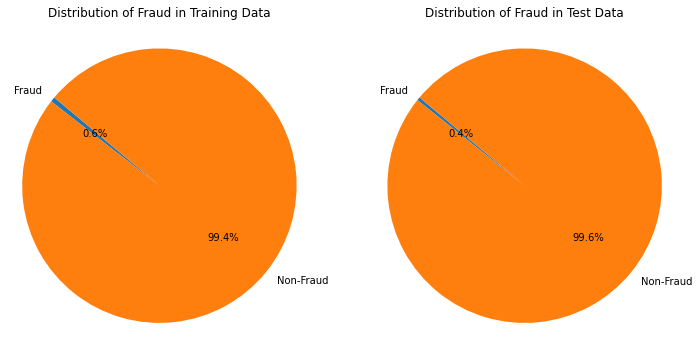

Number of frauds in training data: 7506
Number of non-frauds in training data: 1289169
Number of frauds in test data: 2145
Number of non-frauds in test data: 553574


In [0]:
# Number of fraud and non fraud cases in both datasets
train_frauds = df_train.filter(df_train['is_fraud'] == 1).count()
train_non_frauds = df_train.count() - train_frauds
test_frauds = df_test.filter(df_test['is_fraud'] == 1).count()
test_non_frauds = df_test.count() - test_frauds

# Distribution plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie([train_frauds, train_non_frauds], labels=['Fraud', 'Non-Fraud'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraud in Training Data')
plt.axis('equal') 
plt.subplot(1, 2, 2)
plt.pie([test_frauds, test_non_frauds], labels=['Fraud', 'Non-Fraud'], autopct='%1.1f%%', startangle=140)	
plt.title('Distribution of Fraud in Test Data')
plt.axis('equal')  
plt.show()

print(f'Number of frauds in training data: {train_frauds}')
print(f'Number of non-frauds in training data: {train_non_frauds}')
print(f'Number of frauds in test data: {test_frauds}')
print(f'Number of non-frauds in test data: {test_non_frauds}')

The dataset is clearly imbalanced. I decided instead of changing the data distribution (like undersampling or oversampling), we adjust the loss function to misclassifying a fraud (minority) is penalized more than misclassifying a non-fraud (majority). This will be done in following sections.

#### Numerical features

In this section, I will perform feature engineering to create new features and evaluate the relevance of existing numerical features by analyzing their correlation values with the target variable.

I'm going to start getting the age based on the date of birth (dob) which is in the format YYYY-MM-DD, so we can extract the year from it and calculate the age by subtracting it from the transaction year. We must not use the current year, as we want to avoid data leakage (uses information that wouldn't be available at the time of prediction).

In [0]:
# We applied transaction_year - year of birth
df_train = df_train.withColumn('age', 
                               (year(col('trans_date_trans_time')) - col('dob').substr(1, 4)
                                .cast(IntegerType())))                        
df_test = df_test.withColumn('age', 
                             (year(col('trans_date_trans_time')) - col('dob').substr(1, 4)
                              .cast(IntegerType())))                                        

df_train.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|           1296675|
|   mean| 46.02929801222357|
| stddev|17.382372624741294|
|    min|                14|
|    max|                96|
+-------+------------------+



Now, I will calculate the distance between the customer and the merchant in order to detect unusual behaviours. The features lat, long, merch_lat, and merch_long can be combined by calculating the distance between the customer and the merchant. The distance is computed using the following formula:
$$
\text{Distance between } (x_1,y_1) \text{ and } (x_2, y_2) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

In [0]:
# Extract the distance between the customer and the merchant, using withColumns creates
# a new column in each dataset which will store the distance.
df_train = df_train.withColumn(
    'distance_customer_merchant',
    functions.sqrt(
        (functions.col('lat') - functions.col('merch_lat')) ** 2 +
        (functions.col('long') - functions.col('merch_long')) ** 2
    )
)

df_test = df_test.withColumn(
    'distance_customer_merchant',
    functions.sqrt(
        (functions.col('lat') - functions.col('merch_lat')) ** 2  +
        (functions.col('long') - functions.col('merch_long')) ** 2 
    )
)

df_train.select('distance_customer_merchant').describe().show()

+-------+--------------------------+
|summary|distance_customer_merchant|
+-------+--------------------------+
|  count|                   1296675|
|   mean|        0.7656610714225193|
| stddev|        0.2847484245847595|
|    min|      2.386629422352145...|
|    max|        1.4133643382726842|
+-------+--------------------------+



I capture the typical spending behavior of each user, merchant, and category by grouping transactions based on credit card number (cc_num), category, and merchant, and calculating the average transaction amount for each group. These averages are computed using only the training dataset to avoid data leakage. For any new users, merchants, or categories that appear in the test set (and thus lack these averages), I replace the missing values with 1 to ensure consistency.

In [0]:
# Extract the amount average per user
user_amt_avg = df_train.groupBy("cc_num").agg(
    functions.mean("amt").alias("user_amt_avg")
)

# Extract the amount average per category
category_amt_avg = df_train.groupBy('category').agg(
    functions.mean('amt').alias('category_amt_avg')
)

# Extract the amount average per merchant
merchant_amt_avg = df_train.groupBy('merchant').agg(
    functions.mean('amt').alias('merchant_amt_avg')
)

# Adding information into both dataset, creading a new column called by each alias
df_train = df_train.join(user_amt_avg, on="cc_num", how="left")
df_test = df_test.join(user_amt_avg, on="cc_num", how="left")
df_train = df_train.join(category_amt_avg, on="category", how="left")
df_test = df_test.join(category_amt_avg, on="category", how="left")
df_train = df_train.join(merchant_amt_avg, on="merchant", how="left")
df_test = df_test.join(merchant_amt_avg, on="merchant", how="left")

# New users in the test dataset, replace missing values by 1
df_test = df_test.fillna({'user_amt_avg': 1})
df_test = df_test.fillna({'category_amt_avg': 1})
df_test = df_test.fillna({'merchant_amt_avg': 1})

# Finally, I calculated the relative amount per user (amt/user amt average)
df_train = df_train.withColumn('relative_amt', functions.col('amt') / functions.col('user_amt_avg'))
df_test = df_test.withColumn('relative_amt', functions.col('amt') / functions.col('user_amt_avg'))

df_train.select('user_amt_avg','category_amt_avg','merchant_amt_avg', 'relative_amt').describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|      user_amt_avg|  category_amt_avg|  merchant_amt_avg|        relative_amt|
+-------+------------------+------------------+------------------+--------------------+
|  count|           1296675|           1296675|           1296675|             1296675|
|   mean| 70.35103545607805| 70.35103545603657|   70.351035456073|  1.0000000000000024|
| stddev|19.410290693894147|  20.6279472733389|20.962541663501693|  2.2999175032629178|
|    min|  42.9516710013004| 47.96767811102054| 45.84807986870898|0.008693368698356895|
|    max| 948.8181818181819|116.96098594283319| 165.6534771573604|   386.4815882611676|
+-------+------------------+------------------+------------------+--------------------+



Next, I compute the total number of transactions per user because a higher-than-normal number of transactions can be a strong indicator of suspicious behavior. I also ensure that in the test set, if a completely new user appears (because it has not seen in training), I assign a default value of 1 to avoid introducing nulls into the feature.


In [0]:
# Extract the number of transactions per user
user_transactions_train = df_train.groupBy('cc_num').agg(
    functions.count('*').alias('transactions_per_user')
)
# Adding information to both datasets
df_train = df_train.join(user_transactions_train, on='cc_num', how='left')
df_test = df_test.join(user_transactions_train, on='cc_num', how='left')

# Replace transactions per user of a new user in the test dataset by 1
df_test = df_test.fillna({'transactions_per_user': 1})

Finally, I will extract the hour of each transaction using the "unix_time" feature, which records the number of seconds elapsed since January 1, 1970, at 00:00:00 UTC. Additionally, I will determine the day of the week for each transaction and identify whether it occurred at night, defining nighttime as between 8 PM and 8 AM.

In [0]:
# Convert unix_time into Timestamp
df_train = df_train.withColumn('transaction_timestamp', functions.from_unixtime('unix_time'))
df_test = df_test.withColumn('transaction_timestamp', functions.from_unixtime('unix_time'))

# Extract the hour 
df_train = df_train.withColumn('transaction_hour', functions.hour('transaction_timestamp'))
df_test = df_test.withColumn('transaction_hour', functions.hour('transaction_timestamp'))

# Extract the day
df_train = df_train.withColumn('day_of_week',functions.dayofweek('transaction_timestamp'))
df_test = df_test.withColumn('day_of_week',functions.dayofweek('transaction_timestamp'))

# Extract whether it occured at night (from 8PM to 8 AM)
df_train = df_train.withColumn('is_night',
                               functions.when((functions.col('transaction_hour') < 8) | (functions.col('transaction_hour') > 22), 1)
                               .otherwise(0))
df_test = df_test.withColumn('is_night',
                             functions.when((functions.col('transaction_hour') < 8) | (functions.col('transaction_hour') > 22), 1)
                             .otherwise(0))

df_train.select('transaction_hour','day_of_week','is_night').describe().show()

+-------+------------------+------------------+-------------------+
|summary|  transaction_hour|       day_of_week|           is_night|
+-------+------------------+------------------+-------------------+
|  count|           1296675|           1296675|            1296675|
|   mean|12.804857809397111| 4.183884936472131| 0.3134455434091041|
| stddev| 6.817823899187159|2.1962103879706856|0.46389395413948653|
|    min|                 0|                 1|                  0|
|    max|                23|                 7|                  1|
+-------+------------------+------------------+-------------------+



I will drop the features related to location (since our new feature 'distance_customer_merchant' captures that information) as well as unique identifiers for each transaction (such as '_c0' and 'cc_num'), which do not contribute useful patterns for modeling.

In [0]:
df_train = df_train.drop('lat','long','merch_lat','merch_long','dob','_c0','cc_num')
df_test = df_test.drop('lat','long','merch_lat','merch_long','dob','_c0','cc_num')

Numerical columns: ['amt', 'zip', 'city_pop', 'unix_time', 'is_fraud', 'age', 'distance_customer_merchant', 'user_amt_avg', 'category_amt_avg', 'merchant_amt_avg', 'relative_amt', 'transactions_per_user', 'transaction_hour', 'day_of_week', 'is_night']


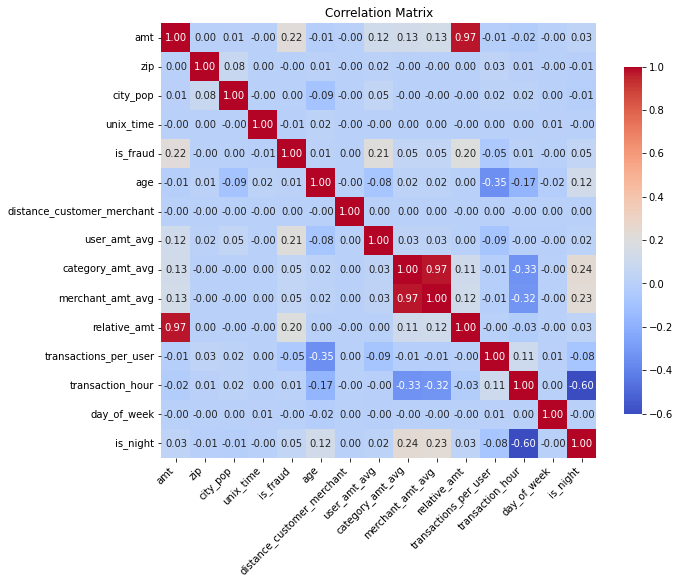

In [0]:
plotting_correlation_matrix(df_train)

Correlation matrix conclusion:

- 'amt', 'user_amt_avg', 'category_amt_avg', 'merchant_amt_avg', 'relative_amt', 'transaction_hour' and 'is_night' are the only variables moderately correlated with is_fraud.
- 'category_amt_avg' will be excluded from the model because it is highly correlated with 'merchant_amt_avg', indicating they capture similar information.
- 'relative_amt' will be excluded because of its strong correlation with 'amt', suggesting redundancy between them.
- 'is_night' will not be included, as I prefer to keep 'transaction_hour', which is more general and provides richer temporal detail.
- Other variables show very low or no correlation with is_fraud, suggesting they are weakly predictive and they should not be included in our model.

In [0]:
numerical_columns = get_columns(df_train)

# Remove 'amt', is_fraud', 'user_avg_amt', 'transaction_hour' and 'merchant_amt_avg' from numerical_columns
numerical_columns.remove('amt')
numerical_columns.remove('is_fraud')
numerical_columns.remove('user_amt_avg')
numerical_columns.remove('transaction_hour')
numerical_columns.remove('merchant_amt_avg')
numerical_columns.remove('age')

# Drop the rest numerical columns from df_train and df_test
df_train = df_train.drop(*numerical_columns)
df_test = df_test.drop(*numerical_columns)

# Remove time-related columns 
df_train = df_train.drop('trans_date_trans_time')
df_test = df_test.drop('trans_date_trans_time')
df_train = df_train.drop('unix_time')
df_test = df_test.drop('unix_time')
df_train = df_train.drop('transaction_timestamp')
df_test = df_test.drop('transaction_timestamp')

#### Categorical features

Let's continue checking the categorical values in the dataset. Depending on the number of unique values and the meaning of the feature, next approaches can be considerated:

- Dropping: For insignifican features.
- StringIndexer: It transforms categorical variables into numerical indices. Other approaches, such as OneHotEncoding, are not considered because tree-based models can naturally handle indexed categorical features without requiring one-hot encoding.


In [0]:
categorical_columns = get_columns(df_train,numerical=False)
print(f'Categorical columns: {categorical_columns}')

Categorical columns: ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'trans_num']


In [0]:
for col_name in categorical_columns:
    print(f'Unique values in {col_name}: {df_train.select(col_name).distinct().count()}')

Unique values in merchant: 693
Unique values in category: 14
Unique values in first: 352
Unique values in last: 481
Unique values in gender: 2
Unique values in street: 983
Unique values in city: 894
Unique values in state: 51
Unique values in job: 494
Unique values in trans_num: 1296675


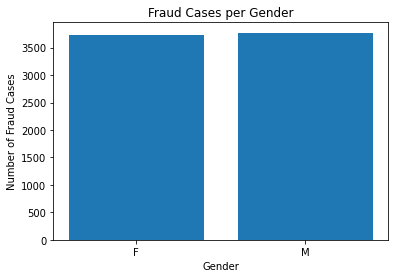

Number of fraud cases (female):3735
Number of fraud cases (men):3771


In [0]:
# Obtain the number of fraud cases and the distribution by genders
fraud_counts = df_train.filter(df_train['is_fraud'] == 1).groupBy('gender').count().collect()
genders = [row['gender'] for row in fraud_counts]
counts = [row['count'] for row in fraud_counts]

plt.figure(figsize=(6, 4))
plt.bar(genders, counts)
plt.xlabel('Gender')
plt.ylabel('Number of Fraud Cases')
plt.title('Fraud Cases per Gender')
plt.show()

print(f'Number of fraud cases (female):{counts[0]}')
print(f'Number of fraud cases (men):{counts[1]}')

The distribution of fraud cases across genders is approximately uniform; therefore, it is reasonable to exclude the gender feature from the modeling process, as it is unlikely to contribute meaningful discriminatory power.

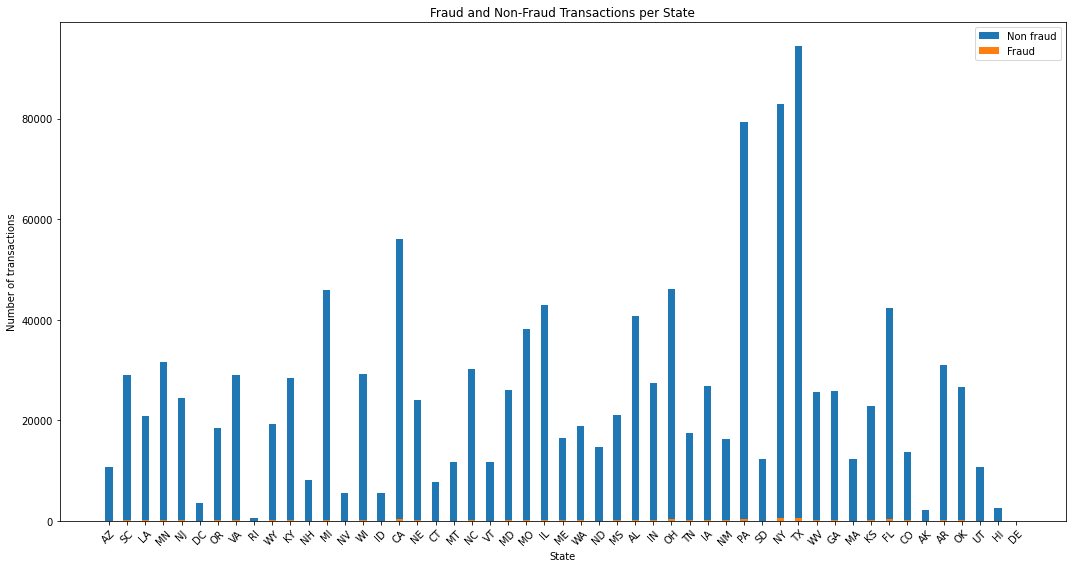

In [0]:
# Distribution of fraud cases by state
fraud_per_state = df_train.groupBy('state','is_fraud').count().collect()

fraud_counts = {}
non_fraud_counts = {}

# Initialize the states with fraud cases
states = [row['state'] for row in df_train.select('state').distinct().collect()]

# Make sure all states are initialized in the dictionaries
for state in states:
    fraud_counts[state] = 0
    non_fraud_counts[state] = 0

for row in fraud_per_state:
    if row['is_fraud'] == 1:
        fraud_counts[row['state']] = row['count']
    else:
        non_fraud_counts[row['state']] = row['count']

plt.figure(figsize=(15,8))
plt.bar(non_fraud_counts.keys(), non_fraud_counts.values(),label='Non fraud',width=0.4)
plt.bar(fraud_counts.keys(), fraud_counts.values(),label='Fraud',width=0.4)
plt.xlabel('State')
plt.ylabel('Number of transactions')
plt.title('Fraud and Non-Fraud Transactions per State')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Some states have a significant number of fraud cases, while others have very few. This suggests that the state feature may be useful for modeling fraud detection. Let's calculate the fraud rate per state to visualize better the fraud distribution by state.

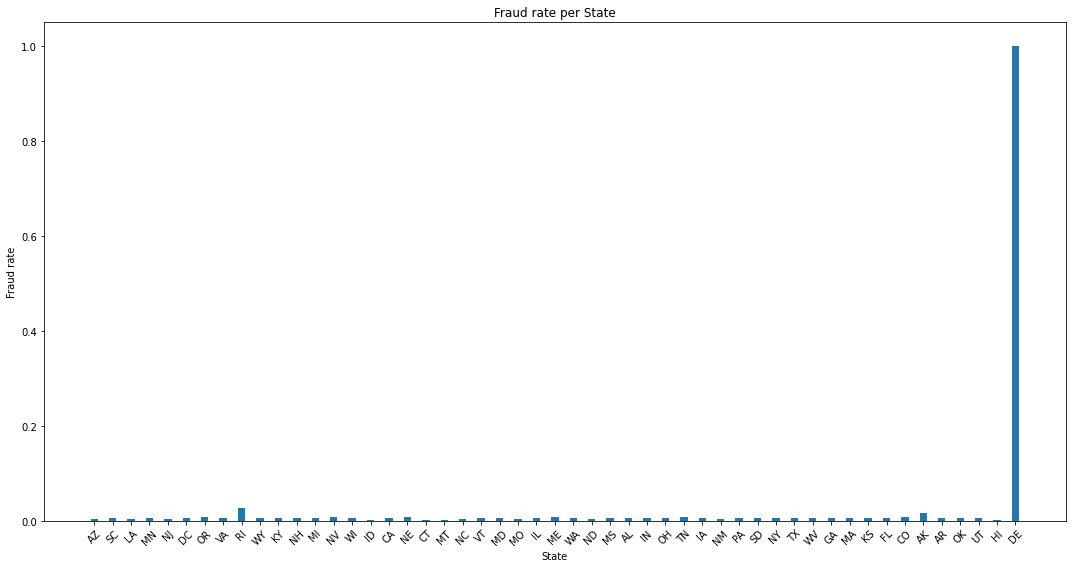

In [0]:
# Convert to arrays
categories = list(non_fraud_counts.keys())
non_fraud_vals = np.array(list(non_fraud_counts.values()))
fraud_vals = np.array(list(fraud_counts.values()))

# Calculate fraud rate
fraud_rate = fraud_vals / (fraud_vals + non_fraud_vals)

plt.figure(figsize=(15,8))
plt.bar(non_fraud_counts.keys(), fraud_rate, width=0.4)
plt.xlabel('State')
plt.ylabel('Fraud rate')
plt.title('Fraud rate per State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the fraud rate by state, certain states exhibit a disproportionately high incidence of fraudulent transactions relative to their total transaction volume. For instance, in the state of Delaware (DL), all recorded transactions were classified as fraudulent. The feature gives important aspects that should be consider by the model.

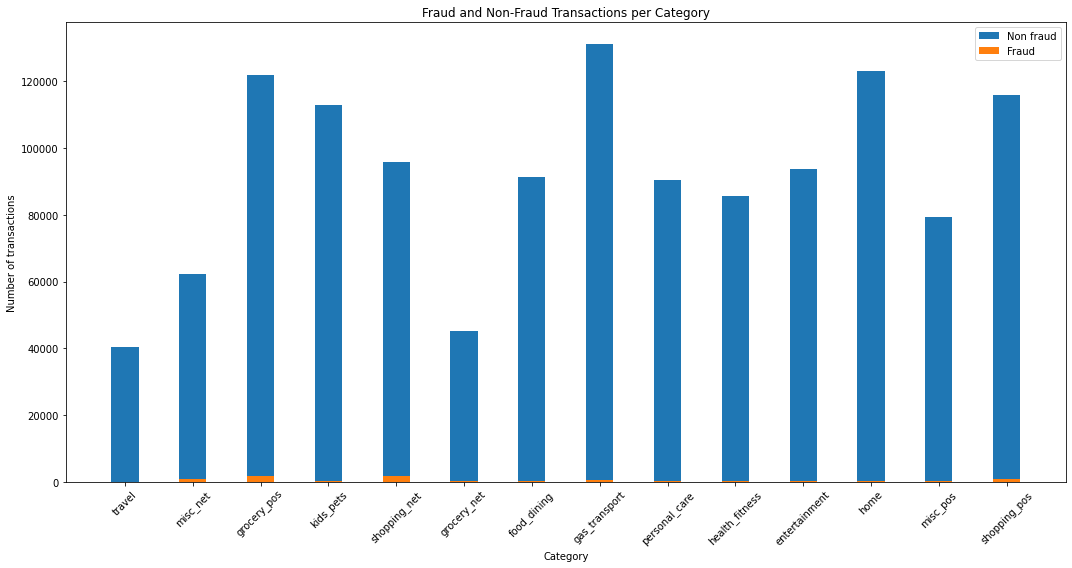

In [0]:
# Similar to the state, we can analyze the fraud distribution by category
fraud_per_category = df_train.groupBy('category','is_fraud').count().collect()

fraud_counts = {}
non_fraud_counts = {}

# Initialize the categories with fraud cases
categories = [row['category'] for row in df_train.select('category').distinct().collect()]

# Make sure all categories are initialized in the dictionaries
for category in categories:
    fraud_counts[category] = 0
    non_fraud_counts[category] = 0

for row in fraud_per_category:
    if row['is_fraud'] == 1:
        fraud_counts[row['category']] = row['count']
    else:
        non_fraud_counts[row['category']] = row['count']

plt.figure(figsize=(15,8))
plt.bar(non_fraud_counts.keys(), non_fraud_counts.values(),label='Non fraud',width=0.4)
plt.bar(fraud_counts.keys(), fraud_counts.values(),label='Fraud',width=0.4)
plt.xlabel('Category')
plt.ylabel('Number of transactions')
plt.title('Fraud and Non-Fraud Transactions per Category')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

We can observe that some categories have more number of fraud cases than others. For example, the category 'glocery_post' has a relevant number of fraud cases. However, plotting the fraud rate per category will give us a breakdown of the fraud distribution by category.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


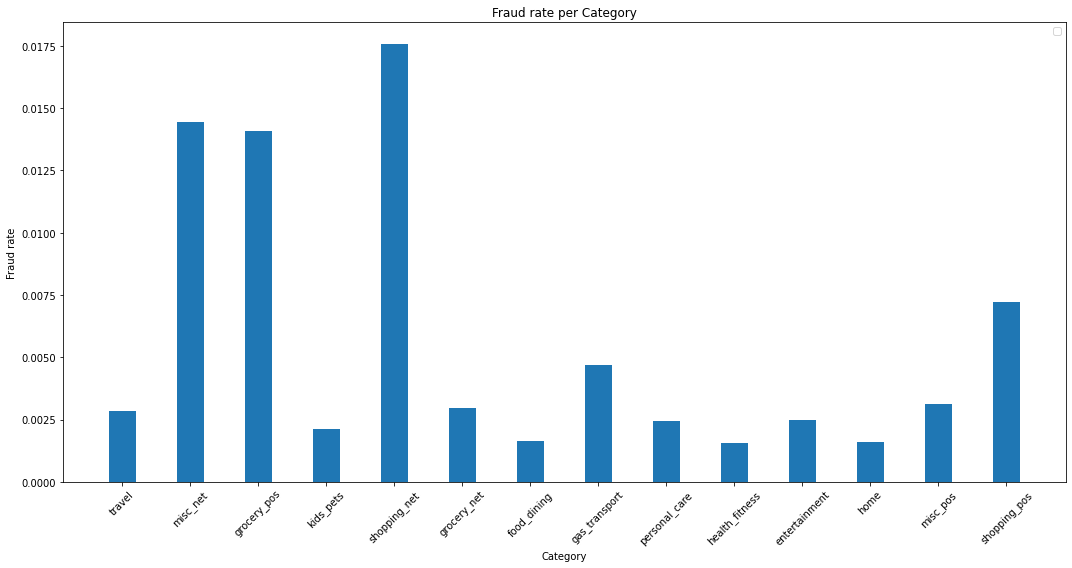

In [0]:
# Convert to arrays
categories = list(non_fraud_counts.keys())
non_fraud_vals = np.array(list(non_fraud_counts.values()))
fraud_vals = np.array(list(fraud_counts.values()))

# Calculate fraud rate
fraud_rate = fraud_vals / (fraud_vals + non_fraud_vals)

plt.figure(figsize=(15,8))
plt.bar(non_fraud_counts.keys(), fraud_rate, width=0.4)
plt.xlabel('Category')
plt.ylabel('Fraud rate')
plt.title('Fraud rate per Category')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

We can observe that some categories have a significant fraud rate with respect to the total number of transactions. For that reason, the category feature may be useful for modeling fraud detection.

Given the high number of unique values in some categorical features, I decided to apply the following strategies for each case:

- merchant: I decided to apply StringIndexer.
- category: I decided to apply StringIndexer.
- First and Last: Firstly, I decided to mergen them and create 'full_name'.
- Gender: I decided to apply StringIndexer.
- Street: I decided to drop it because it is over personalized. It does not make sense to keep it if I dropped numerical variables like 'lat' or 'long'.
- City: It does not make sense to keep it because it's too specific.
- State: I decided to keep it and apply StringIndexer.
- Job: I decided to apply StringIndexer.
- trans_num: I decided to drop it because it does not add any information as it is an unique value for each case.

In [0]:
df_train = df_train.withColumn('full_name', concat_ws(' ', df_train['first'], df_train['last']))
df_test = df_test.withColumn('full_name', concat_ws(' ', df_test['first'], df_test['last']))

I will create risk-based features by calculating the fraud risk (mean of frauds) for each client, merchant, category, and job using the training data. These aggregated risk metrics are then joined back to both the training and test datasets to add contextual fraud risk information. To handle unseen categories in the test set, missing values are filled with a default of 1.

In [0]:
# Fraud risk based on users, merchants, categories, and jobs
client_risk_rate = df_train.groupBy('full_name').agg(functions.mean('is_Fraud').alias('client_risk_rate'))
merchant_risk_rate = df_train.groupBy('merchant').agg(functions.mean('is_Fraud').alias('merchant_risk_rate'))
category_risk_rate = df_train.groupBy('category').agg(functions.mean('is_fraud').alias('category_risk_rate'))
job_risk_rate = df_train.groupBy('job').agg(functions.mean('is_fraud').alias('job_risk_rate'))

# Adding information to both datasets
df_train = df_train.join(client_risk_rate,on='full_name',how='left')
df_train = df_train.join(merchant_risk_rate,on='merchant',how='left')
df_train = df_train.join(category_risk_rate,on='category',how='left')
df_train = df_train.join(job_risk_rate,on='job',how='left')

df_test = df_test.join(client_risk_rate,on='full_name',how='left')
df_test = df_test.join(merchant_risk_rate,on='merchant',how='left')
df_test = df_test.join(category_risk_rate,on='category',how='left')
df_test = df_test.join(job_risk_rate,on='job',how='left')

# Unseen cases are filled with 1
df_test = df_test.fillna({'client_risk_rate': 1})
df_test = df_test.fillna({'merchant_risk_rate': 1})
df_test = df_test.fillna({'category_risk_rate': 1})
df_test = df_test.fillna({'job_risk_rate': 1})

Now, let's combine all the previously engineered risk features into a single feature called transaction_risk, which aggregates the effects of client, merchant, category, and job risk. We compute it as the product of the log-transformed risk rates (I used log to make the distribution more balanced and easier for the model to learn from)

In [0]:
# Transaction_risk = client_risk * merchant_risk * category_risk * job_risk
# Remember log1p(x) = log(1 + x)
df_train = df_train.withColumn('transaction_risk', functions.log1p('client_risk_rate') *
                               functions.log1p('merchant_risk_rate') * functions.log1p('category_risk_rate')
                               * functions.log1p('job_risk_rate'))
df_test = df_test.withColumn('transaction_risk', functions.log1p('client_risk_rate') *
                               functions.log1p('merchant_risk_rate') * functions.log1p('category_risk_rate')
                               * functions.log1p('job_risk_rate'))

Now, let's see the correlation of our new features

Numerical columns: ['amt', 'is_fraud', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour', 'client_risk_rate', 'merchant_risk_rate', 'category_risk_rate', 'job_risk_rate', 'transaction_risk']


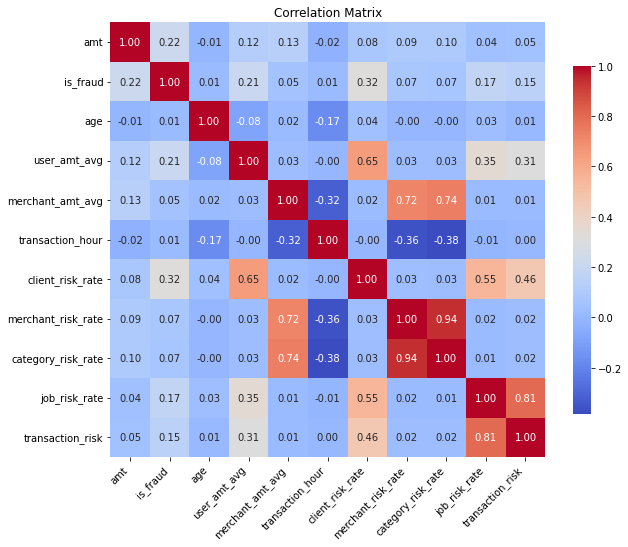

In [0]:
plotting_correlation_matrix(df_train)

Correlation matrix conclusion:

- 'client_risk_rate', 'job_risk_rate' and 'transaction_risk' have high correlation with 'user_amt_avg', for this reason I decided do not include them into the model.
- 'merchant_risk_rate' and 'category_risk_rate' have high correlation with ´merchant_amt_avg', therefore I decided do not include them into the model.

In [0]:
df_train = df_train.drop('first', 'last', 'street', 'city', 'trans_num','gender',
                        'category_risk_rate', 'merchant_risk_rate','client_risk_rate','job_risk_rate','transaction_risk')
df_test = df_test.drop('first', 'last', 'street', 'city', 'trans_num','gender',
                       'category_risk_rate', 'merchant_risk_rate','client_risk_rate','job_risk_rate','transaction_risk')

#### Saving Processed Data

In the previous steps, I applied my changes to both datasets. Now, let's proceed to save the results to avoid re-running all the previous process

In [0]:
# Write the final dataframe into FileStore
df_train.write.mode("overwrite").parquet("/FileStore/dataframe/train")
df_test.write.mode("overwrite").parquet("/FileStore/dataframe/test")

In [0]:
# Read the final dataframes from FileStore to avoid rerunning the whole process
df_train = spark.read.parquet("/FileStore/dataframe/train")
df_test = spark.read.parquet("/FileStore/dataframe/test")

# Number of fraud and non fraud cases in train dataset
train_frauds = df_train.filter(df_train['is_fraud'] == 1).count()
train_non_frauds = df_train.count() - train_frauds

#### Pipeline preparation

I will implement the pipeline in this section. A pipeline is machine learning workflow by chaining together multiple stages like preprocessing, feature engineering, and model training. A Spark pipeline is made of two types of stages:

- Transformer: Transform the data into another. For numerical features, no transformation will be applied. Meanwhile, StringIndexer will be applied for categorical features.
- Estimator: It is our model as learns from our data.

In [0]:
# Get the input columns for our model
numerical_columns = get_columns(df_train)
categorical_columns = get_columns(df_train,numerical=False)

# Remove the target column from the input model
numerical_columns.remove('is_fraud')

print(f'Numerical_columns: {numerical_columns}')
print(f'Categorical_columns: {categorical_columns}')    
print(f'Final features: {numerical_columns + categorical_columns}\n')
print(f'Columns in training set: {df_train.columns}')
print(f'Columns in test set: {df_test.columns}')

Numerical_columns: ['amt', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour']
Categorical_columns: ['job', 'category', 'merchant', 'full_name', 'state']
Final features: ['amt', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour', 'job', 'category', 'merchant', 'full_name', 'state']

Columns in training set: ['job', 'category', 'merchant', 'full_name', 'amt', 'state', 'is_fraud', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour']
Columns in test set: ['job', 'category', 'merchant', 'full_name', 'amt', 'state', 'is_fraud', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour']


As we seen previously, our dataset is clearly imbalanced because 99.4 % of data belongs to one specific class. I decided to implement class weight to deal with this issue.

As we know, a pipeline is composed of transformers and estimators. In this case, the transformer applies StringIndexer to the categorical features and then merges the indexed features with the selected numerical features using the VectorAssembler. The behavior of StringIndexer is illustrated below:

$$
\text{StringIndexer}(
\begin{bmatrix}
Walmart \\
Target \\
Walmart \\
Starbucks
\end{bmatrix})
=
\begin{bmatrix}
0.0 \\
1.0 \\
0.0 \\
2.0
\end{bmatrix}
$$

The behavior of VectorAssembler is illustrated below:

$$
\text{VectorAssembler}(\text{'amt'}, \text{'distance\_customer\_merchant'}, \dots, \text{'job\_index\_index'})
=
\begin{bmatrix}
23.5 & 0.12 & \dots & 0.0 \\
10.5 & 0.2 & \dots & 1.0 \\
\vdots & \vdots & \vdots & \ddots \\
5.5 & 0.15 & \dots & 4.0
\end{bmatrix}
$$

I will train and evaluate four different classification models using the same preprocessing pipeline. First, I will apply Naive Bayes, a probabilistic model based on Bayes’ theorem, which works well with categorical data. 

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{Naive Bayes}
$$

Second, I will use Logistic Regression, a linear model that estimates class probabilities and is suitable for binary classification tasks. 

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{Logistic Regression}
$$

Next, I will test a Random Forest, an ensemble method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting. 

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{Random Forest}
$$

Then, I will implement a Support Vector Classifier (SVC), which aims to find the optimal hyperplane that separates classes with the maximum margin.

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{Support Vector Classifier}
$$

Finally, I selected eXtreme Gradient Boosting (XGBoost) and LightGBM as the primary models due to their superior performance in structured data tasks compared to simpler models like Logistic Regression or Random Forest.

XGBoost is an optimized, high-performance implementation of gradient boosting that builds an ensemble of decision trees. It follows a boosting strategy where each new tree is trained to correct the errors of the previous ones. XGBoost supports parallel processing and efficient handling of large datasets, with extensive hyperparameter customization to adapt to specific problems.

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{XGB} 
$$

On the other hand, LightGBM (Light Gradient Boosting Machine), developed by Microsoft, is a fast and scalable gradient boosting framework. It uses a histogram-based learning algorithm that significantly reduces training time and memory usage. LightGBM also supports GPU acceleration and distributed learning, making it ideal for large-scale machine learning tasks.

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{LightGBM}
$$

In order to improve our results, I decided to combine both models with Logistic Regression and Support Vector Classifier by using the predicted probabilities from each boosting model as additional input features for both models. My idea is the second classifier could learn patterns that the base models missed, especially for borderline cases. This strategy allowed both models to refine the decision boundary based on richer, model-informed features.

Based on these advantages, I designed the next different pipelines combining both XGBoost and LightGBM to explore their strengths in the context of fraud detection.

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{XGB} \rightarrow \text{VectorAssembler} \rightarrow \text{Support Vector Classifier}
$$

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{XGB} \rightarrow \text{VectorAssembler} \rightarrow \text{Logistic Regression}
$$

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{LightGBM} \rightarrow \text{VectorAssembler} \rightarrow \text{Support Vector Classifier}
$$

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{LightGBM} \rightarrow \text{VectorAssembler} \rightarrow \text{Logistic Regression}
$$

In [0]:
# StringIndexers for categorical columns (convert categorical into numerical)
indexers = [
    StringIndexer(inputCol=col, outputCol=f'{col}_index', handleInvalid='keep')
    for col in categorical_columns
]

# Features for VectorAssembler
# - numerical columns stay as they are
# - categorical columns are replaced after apply StringIndexers

final_features = numerical_columns + [f'{col}_index' for col in categorical_columns]

fraud_weight = df_train.count() / (2.0 * train_frauds)
non_fraud_weight = df_train.count() / (2.0 * train_non_frauds)

df_train = df_train.withColumn('weight', 
                               functions.when(df_train['is_fraud'] == 1, fraud_weight).otherwise(non_fraud_weight))

# -------------------------------------------------------Assemblers------------------------------------------------------------------
# Assemble all features into 'features'
first_assembler = VectorAssembler(
                        inputCols=final_features,               # Name of the columns to be assembled (mumerical + categoricals_index)
                        outputCol='features'                    # Output column
)

# Assemble all features + probability calculated by XGB
xgb_assembler = VectorAssembler(
                        inputCols=['features', 'xgb_prob'],     # Columns to convert into a vector
                        outputCol='xgb_features'                # Output column
)

# Assemble all features + probability calculated by LightGBM
gbm_assembler = VectorAssembler(
                        inputCols=['features', 'gbm_prob'],     # Columns to convert into a vector
                        outputCol='gbm_features'                # Output column
)

# -------------------------------------------------------Models----------------------------------------------------------------------

# Naive Bayes
nb = NaiveBayes(
                labelCol='is_fraud',                            # Target column
                featuresCol='features',                         # Input of the model
)

# Logistic Regression
lr = LogisticRegression(
                        labelCol='is_fraud',                    # Target column
                        featuresCol='features',                 # Input of the model
                        maxIter=100,                            # Maximum number of iterations
                        threshold=0.05,                         # Adjust the probability of predicting each class                
)

# Random Forest
rf = RandomForestClassifier(
                           labelCol='is_fraud',                 # Target column
                           featuresCol='features',              # Input of the model
                           maxDepth=6,                          # Depth of the tree
                           numTrees=200,                        # Number of trees
                           maxBins=1024,
)

# LinearSVC
svc = LinearSVC(
                labelCol='is_fraud',                            # Target column
                featuresCol='features',                         # Input of the model
                maxIter=200,                                    # Number of iterations
                threshold=0.7,
                weightCol='weight'
)

# XGB Classifier
xgb = SparkXGBClassifier(
                        label_col='is_fraud',                   # Target column
                        features_col='features',                # Input for the model
                        scale_pos_weight=fraud_weight,          # Handle with imbalanced dataset, typically negative_samples/positive_samples
                        eta=0.1,                                # Learning rate (by default 0.3)          
                        num_round=200,                          # Number of iterations (by default 100)
                        prediction_col='xgb_pred',              # Predictions (probability calculated)
                        probability_col='xgb_prob',             # 1 if prediction >= 0.5 else 0
                        raw_prediction_col='xgb_raw'            # Confident interval
)

# LightGBM Classifier
gbm = LightGBMClassifier(
                        labelCol='is_fraud',                    # Target column
                        featuresCol='features',                 # Input for the model
                        isUnbalance=True,                       # Handle imbalanced dataset 
                        learningRate=0.05,                      # Learning rate
                        numIterations=300,                      # Number of iterations
                        numLeaves=64,                           # Number of leaves
                        maxDepth=8,                             # Depth of the tree
                        predictionCol='gbm_prediction',         # Predictions (probability calculated)
                        probabilityCol='gbm_prob',              # 1 if prediction >= threshold else 0
                        rawPredictionCol='gbm_raw',             # Confident interval
)

# Logistic Regression classifier (standarize by default)
xgb_lr = LogisticRegression(
                        labelCol='is_fraud',                    # Target column
                        featuresCol='xgb_features',             # Input of the model
                        maxIter=100,                            # Maximum number of iterations
                        threshold=0.5,                          # Adjust the probability of predicting each class
)

# Logistic Regression classifier (standarize by default)
gbm_lr = LogisticRegression(
                        labelCol='is_fraud',                    # Target column
                        featuresCol='gbm_features',             # Input of the model
                        maxIter=100,                            # Maximum number of iterations
                        threshold=0.001,                        # Adjust the probability of predicting each class
)

# Support Vector Classifier (standarize by default)
xgb_svc = LinearSVC(
                    labelCol='is_fraud',                    # Target column
                    featuresCol='xgb_features',             # Input of the model
                    maxIter=200,                            # Maximum number of iterations
                    threshold=0.9,                          # Adjust the probability of predicting each class
                    weightCol='weight'
)

# Support Vector Classifier classifier (standarize by default)
gbm_svc = LinearSVC(
                    labelCol='is_fraud',                    # Target column
                    featuresCol='gbm_features',             # Input of the model
                    maxIter=200,                            # Maximum number of iterations
                    threshold=0.001,                        # Adjust the probability of predicting each class
                    weightCol='weight'
)

print(f'Final features included in the model: {final_features}')

# -------------------------------------------------------Pipelines-------------------------------------------------------------------

nb_pipeline = Pipeline(stages=indexers + [first_assembler, nb])
lr_pipeline = Pipeline(stages=indexers + [first_assembler, lr])
rf_pipeline = Pipeline(stages=indexers + [first_assembler, rf])
svc_pipeline = Pipeline(stages=indexers + [first_assembler, svc])

xgb_pipeline = Pipeline(stages=indexers + [first_assembler, xgb])
gbm_pipeline = Pipeline(stages=indexers + [first_assembler, gbm])
xgb_lr_pipeline = Pipeline(stages=indexers + [first_assembler, xgb, xgb_assembler, xgb_lr])
gbm_lr_pipeline = Pipeline(stages=indexers + [first_assembler, gbm, gbm_assembler, gbm_lr])
xgb_svc_pipeline = Pipeline(stages=indexers + [first_assembler, xgb, xgb_assembler, xgb_svc])
gbm_svc_pipeline = Pipeline(stages=indexers + [first_assembler, gbm, gbm_assembler, gbm_svc])

Final features included in the model: ['amt', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour', 'job_index', 'category_index', 'merchant_index', 'full_name_index', 'state_index']


#### Single models: Training and results

In this section, I will train the next models: Naive Bayes, Logistic Regression, Random Forest and Support Vector Classfier. The objective is to select the best models to use them after.

In [0]:
# Naive Bayes
nb_model = nb_pipeline.fit(df_train)                      # Training the model
nb_predictions = nb_model.transform(df_test)              # Predictions based on the trained model

In [0]:
# Logistic Regression
lr_model = lr_pipeline.fit(df_train)                      # Training the model
lr_predictions = lr_model.transform(df_test)              # Predictions based on the trained model

In [0]:
# Random Forest
rf_model = rf_pipeline.fit(df_train)                      # Training the model
rf_predictions = rf_model.transform(df_test)              # Predictions based on the trained model

In [0]:
# Support Vector Classifier
svc_model = svc_pipeline.fit(df_train)                      # Training the model
svc_predictions = svc_model.transform(df_test)              # Predictions based on the trained model

---Naive Bayes---
Accuracy: 0.9110
Precision: 0.0320
Sensibility or Recall: 0.7529
Specificity: 0.9117
F1-Score: 0.0613

---Logistic Regression---
Accuracy: 0.9943
Precision: 0.2745
Sensibility or Recall: 0.2937
Specificity: 0.9970
F1-Score: 0.2838

---Random Forest---
Accuracy: 0.9979
Precision: 0.9428
Sensibility or Recall: 0.4765
Specificity: 0.9999
F1-Score: 0.6330

---Support Vector Classification (SVC)---
Accuracy: 0.9823
Precision: 0.1397
Sensibility or Recall: 0.6942
Specificity: 0.9834
F1-Score: 0.2326



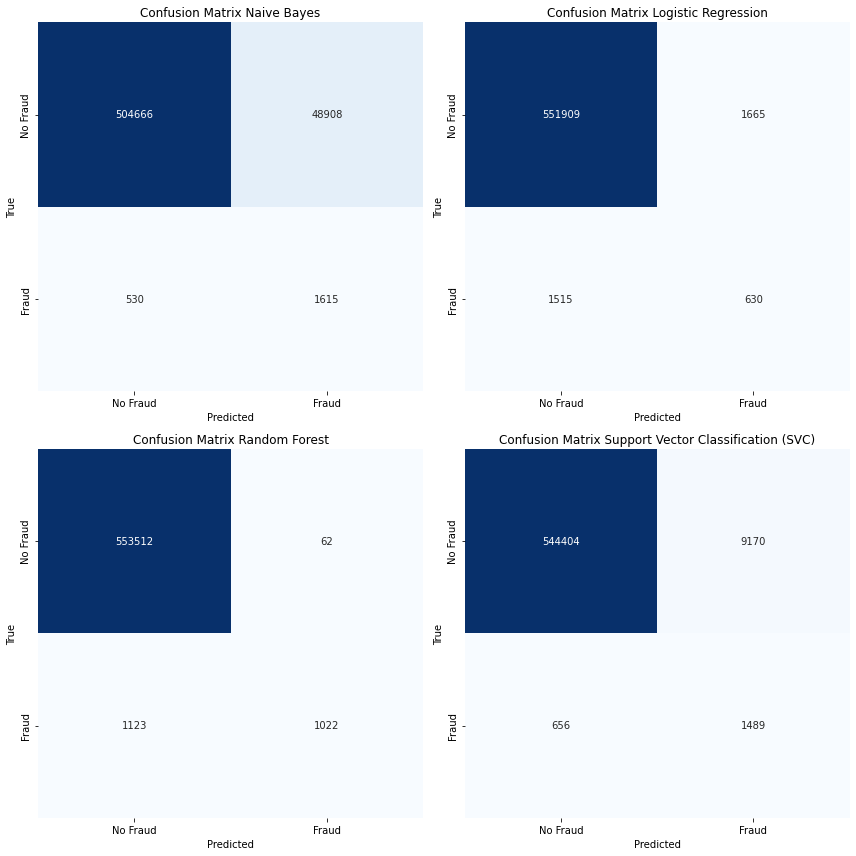

In [0]:
# List to iterate in our loop
predictions = [                                                                                # [predictions,title,prediction_column]
    (nb_predictions, 'Naive Bayes', 'prediction'),
    (lr_predictions, 'Logistic Regression', 'prediction'),
    (rf_predictions, 'Random Forest', 'prediction'),
    (svc_predictions, 'Support Vector Classification (SVC)', 'prediction'),
]

plotting_results(predictions)

Naive Bayes achieved an accuracy of 91.10% and a very high recall of 75.29%, meaning it successfully identified the majority of fraudulent transactions. However, its precision was extremely low (3.20%), indicating a large number of false positives—many transactions were flagged as fraud when they were actually legitimate. The F1-score, a harmonic mean of precision and recall, was just 6.13%. This model may be appropriate in scenarios where detecting as many frauds as possible is critical and false alarms are acceptable.

Logistic Regression showed much stronger balance, with an accuracy of 99.43% and precision of 27.45%. It had a moderate recall of 29.37%, which means it missed a good number of fraudulent cases but generated fewer false positives than Naive Bayes. The F1-score was 28.38%, indicating improved overall performance. Logistic Regression is a reasonable baseline model that is interpretable and performs reliably without too much overfitting or noise.

Random Forest delivered the best results overall. With an accuracy of 99.79%, a precision of 94.28%, and a specificity of 99.99%, it is excellent at correctly classifying non-fraudulent transactions. Although its recall was moderate at 47.65%, meaning it missed some frauds, the trade-off is that its predictions are highly trustworthy when it does flag fraud. The F1-score of 63.30% confirms strong overall performance. This model is ideal when false positives are costly and the goal is to maintain high precision. 

Support Vector Classification (SVC) provided a strong recall of 69.42%, better than both Logistic Regression and Random Forest. This indicates it detected a good number of fraudulent cases. However, precision was relatively low at 13.97%, meaning it produced more false alarms than Logistic Regression or Random Forest. With an F1-score of 23.26%, it stands between Naive Bayes and Logistic Regression in terms of balance. SVC is a suitable model when catching fraud is important, but not at the expense of a very high false positive rate.

Now, let´s save the weights for each model to avoid rerunning.

In [0]:
# Remove the previous models
dbutils.fs.rm('/FileStore/models/', True)

# Save the current models
nb_model.save("/FileStore/models/nb_model")
lr_model.save("/FileStore/models/lr_model")
rf_model.save("/FileStore/models/rf_model")
svc_model.save("/FileStore/models/svc_model")

After these results, I discarded Naive Bayes (poor precision because it has a large number of false positives), and Random Forest (trees are the based of XGB and LIghtGBM, I want to try a different type of model to learn different from data). Now, I will ensamble XGB and LightGBM with Logistic Regression and Support Vector to enhance the performance of XGB and LightGBM. Ensamble models is a common way to improve the performance, quite common in areas like Computer Vision.

#### Ensamble models: Training and results

Ensemble models are machine learning methods that combine multiple models to improve predictive performance, robustness, and generalization compared to a single model. In this section, I will combine Logistic Regression and Support Vector Classifier with XGB and LightGBM to enhance our results.

In [0]:
# LightGBM Classifier
gbm_model = gbm_pipeline.fit(df_train)                      # Training the model
gbm_predictions = gbm_model.transform(df_test)              # Predictions based on the trained model

In [0]:
# LightGBM Classifier + Logistic Regression
gbm_lr_model = gbm_lr_pipeline.fit(df_train)                # Training the model
gbm_lr_predictions = gbm_lr_model.transform(df_test)        # Predictions based on the trained model

In [0]:
# LightGBM Classifier + Support Vector Classifier
gbm_svc_model = gbm_svc_pipeline.fit(df_train)              # Training the model
gbm_svc_predictions = gbm_svc_model.transform(df_test)      # Predictions based on the trained model

In [0]:
# XGBoost Classifier
xgb_model = xgb_pipeline.fit(df_train)                      # Training the model
xgb_predictions = xgb_model.transform(df_test)              # Predictions based on the trained model

/local_disk0/.ephemeral_nfs/envs/pythonEnv-3a2e1373-621f-4f68-bf34-75f5ef886533/lib/python3.9/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [0]:
# XGBoost Classifier + Logistic Regression
xgb_lr_model = xgb_lr_pipeline.fit(df_train)                # Training the model
xgb_lr_predictions = xgb_lr_model.transform(df_test)        # Predictions based on the trained model

In [0]:
# XGBoost Classifier + Support Vector Classifier
xgb_svc_model = xgb_svc_pipeline.fit(df_train)              # Training the model
xgb_svc_predictions = xgb_svc_model.transform(df_test)      # Predictions based on the trained model

---XGB---
Accuracy: 0.9908
Precision: 0.2865
Sensibility or Recall: 0.9329
Specificity: 0.9910
F1-Score: 0.4384

---LightGBM---
Accuracy: 0.9972
Precision: 0.6243
Sensibility or Recall: 0.6886
Specificity: 0.9984
F1-Score: 0.6548

---XGB + Logistic Regression---
Accuracy: 0.9983
Precision: 0.7900
Sensibility or Recall: 0.7772
Specificity: 0.9992
F1-Score: 0.7835

---LightGBM + Logistic Regression---
Accuracy: 0.9980
Precision: 0.8559
Sensibility or Recall: 0.5786
Specificity: 0.9996
F1-Score: 0.6904



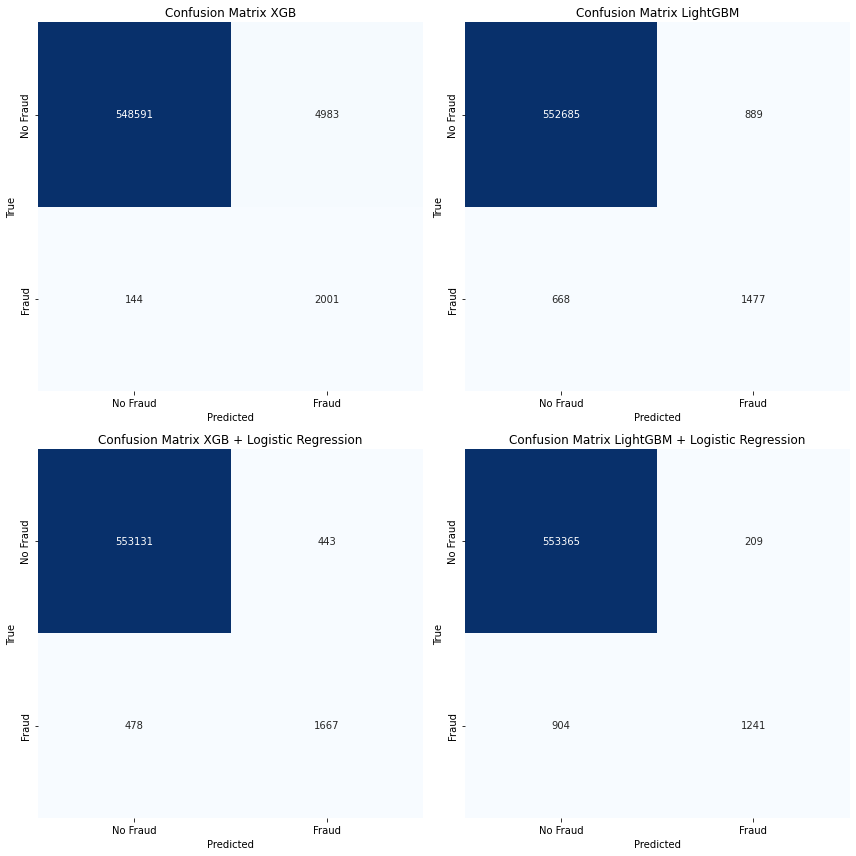

In [0]:
# List to iterate in our loop
predictions = [                                                                                # [predictions,title,prediction_column]
    (xgb_predictions, 'XGB', 'xgb_pred'),
    (gbm_predictions, 'LightGBM', 'gbm_prediction'),
    (xgb_lr_predictions, 'XGB + Logistic Regression', 'prediction'),
    (gbm_lr_predictions, 'LightGBM + Logistic Regression', 'prediction'),
]

plotting_results(predictions)

XGBoost delivered a strong performance, achieving an accuracy of 99.08% and a very high recall of 93.29%, which indicates its effectiveness in capturing fraudulent transactions. However, its precision was 28.65%, which means that more than 70% of its fraud predictions were false positives. Despite this, the model's F1-score of 43.84% shows that it finds a good balance between identifying fraud and maintaining reasonable prediction quality. This model is valuable when it’s critical to catch as many fraud cases as possible, even at the cost of higher false alarms.

The LightGBM model improved upon XGBoost in terms of overall balance, with an accuracy of 99.72%, a precision of 62.43%, and a recall of 68.86%. This means that it reduced the number of false positives significantly while still capturing a high number of fraud cases. The F1-score of 65.48% reflects this well-balanced trade-off. LightGBM would be a better fit if your goal is to minimize false alarms while still detecting a solid portion of fraudulent activities.

The first hybrid model combines the predictive power of XGBoost with the linear separability of Logistic Regression, leading to the best performance overall. It achieved an accuracy of 99.83%, a precision of 79.00%, and a recall of 77.72%, with a F1-score of 78.35%. The improvement in both precision and recall shows that the model is not only highly accurate but also very reliable in identifying fraud. This makes it a great choice for deployment in real-world systems where both false positives and false negatives are costly.

The combination of LightGBM and Logistic Regression yielded the highest precision at 85.59%, meaning that when it predicted fraud, it was correct most of the time. However, its recall was 57.86%, lower than the other models, so it missed a larger portion of actual fraud cases. Despite that, the F1-score of 69.04% remains strong due to its excellent precision. This model is ideal when you prefer high-confidence fraud predictions, even if it means missing some frauds.

---XGB + Logistic Regression---
Accuracy: 0.9983
Precision: 0.7900
Sensibility or Recall: 0.7772
Specificity: 0.9992
F1-Score: 0.7835

---LightGBM + Logistic Regression---
Accuracy: 0.9980
Precision: 0.8559
Sensibility or Recall: 0.5786
Specificity: 0.9996
F1-Score: 0.6904

---XGB + Support Vector Classifier---
Accuracy: 0.9929
Precision: 0.3432
Sensibility or Recall: 0.9124
Specificity: 0.9932
F1-Score: 0.4988

---LightGBM + Support Vector Classifier---
Accuracy: 0.9979
Precision: 0.7921
Sensibility or Recall: 0.6200
Specificity: 0.9994
F1-Score: 0.6956



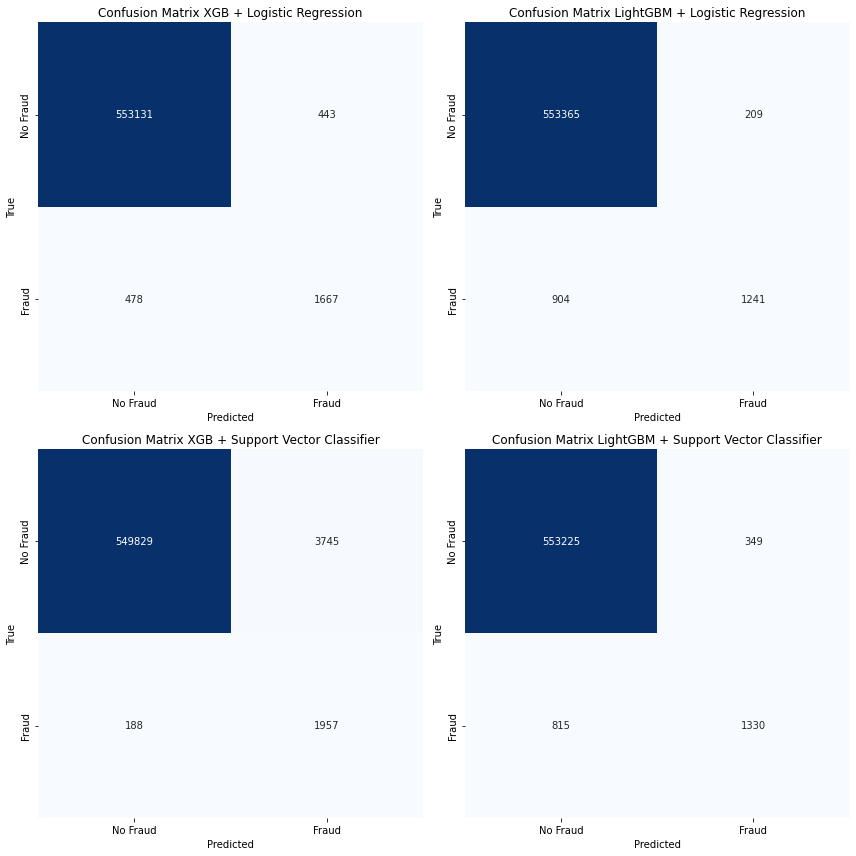

In [0]:
# List to iterate in our loop
predictions = [                                                                                # [predictions,title,prediction_column]
    (xgb_lr_predictions, 'XGB + Logistic Regression', 'prediction'),
    (gbm_lr_predictions, 'LightGBM + Logistic Regression', 'prediction'),
    (xgb_svc_predictions, 'XGB + Support Vector Classifier', 'prediction'),
    (gbm_svc_predictions, 'LightGBM + Support Vector Classifier', 'prediction'),
]

plotting_results(predictions)

The XGBoost + Support Vector Classifier (SVC) model demonstrates an excellent ability to detect fraudulent cases, as shown by its high recall of 91.24%, meaning it captures most of the true fraud instances. However, it does so at the cost of precision (34.32%), resulting in a significant number of false positives. Its overall accuracy is 99.29%, and the F1-score is 49.88%, reflecting a model that strongly favors sensitivity over precision. This makes it well-suited for scenarios where missing a fraud is far more critical than flagging too many legitimate cases.

The LightGBM + Support Vector Classifier offers a more balanced performance. It achieves a precision of 79.21%, which means most of the fraud alerts are correct, and a moderate recall of 62.00%, ensuring a good proportion of actual frauds are detected. With an F1-score of 69.56%, accuracy of 99.79%, and specificity of 99.94%, this model stands out as a reliable option that maintains both precision and recall at acceptable levels without compromising too much on either.

In comparison with the earlier models using Logistic Regression, the XGB + Logistic Regression combination still offers the best overall balance with an F1-score of 78.35%, closely followed by LightGBM + Logistic Regression and LightGBM + SVC. The XGB + SVC model, while leading in recall, lags significantly in precision, which may not be desirable in all contexts. Therefore, for general use where both precision and recall matter, XGB + Logistic Regression remains the strongest candidate, while LightGBM + SVC serves as a strong alternative when slightly more emphasis is placed on precision without heavily compromising recall.

#### Conclusion

Based on these results, we can conclude that LightGBM offers a more balanced performance overall compared to XGBoost. However, in the context of fraud detection, **maximizing the detection of true positive cases is critical,** as failing to identify fraudulent transactions can be highly costly. For this reason, **I believe XGBoost-based models are more suitable,** even if they produce more false positives. A standalone XGBoost model demonstrates strong performance in identifying the majority of true fraud cases, and **its ensembles with Logistic Regression and Support Vector Classifier further improve balance,** making them reliable options for practical deployment. 

In [0]:
# Save the current models to avoid re-training
xgb_model.save("/FileStore/models/xgb_model")
xgb_lr_model.save("/FileStore/models/xgb_lr_model")
gbm_model.save("/FileStore/models/gbm_model")
gbm_lr_model.save("/FileStore/models/gbm_lr_model")

#### Feature Importance and Model Interpretability

In this section, I will analyze which features are most relevant for our models and use SHAP (SHapley Additive exPlanations) to interpret the model. SHAP provides a unified framework based on cooperative game theory that explains the contribution of each feature to a given prediction. It assigns each feature a SHAP value, representing how much that feature increases or decreases the prediction compared to the model's average output. This allows us to understand not just which features are important globally, but also how they influence individual predictions, making the model more transparent and trustworthy.

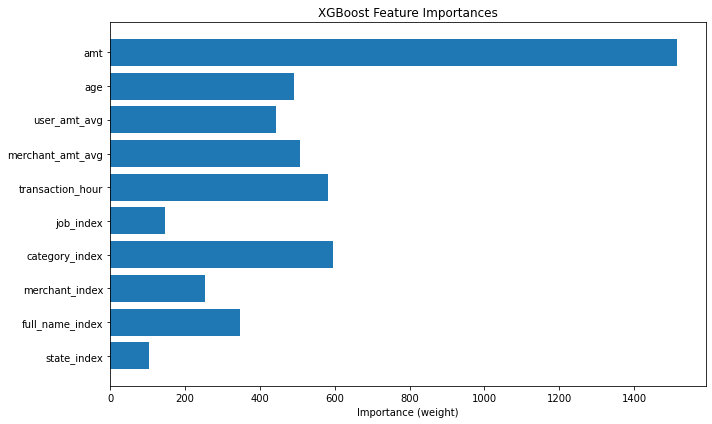

In [0]:
# Get the feature importances from the model
xgb_model_stage = xgb_model.stages[-1]                                          # Get the last stage of the pipeline which is the XGB model
booster = xgb_model_stage.get_booster()                             

feature_importances = booster.get_score(importance_type='weight')               # weights is the number of times a feature is used to split the data across all trees

feature_mapping = {f"f{i}": name for i, name in enumerate(final_features)}

labels = []
scores = []

for i, name in enumerate(final_features):                                       # For each feature, we get the importance score
    fkey = f"f{i}"
    labels.append(name)
    scores.append(feature_importances.get(fkey, 0))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(labels, scores)
plt.xlabel("Importance (weight)")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

The most important feature for the XGBoost model, as shown in the plot, is amt (transaction amount). This variable stands out significantly compared to the rest, indicating that the amount involved in a transaction plays a crucial role in the model’s ability to detect fraud. Its dominant position in the feature importance ranking suggests that the model heavily relies on transaction amount to differentiate between fraudulent and non-fraudulent activities.

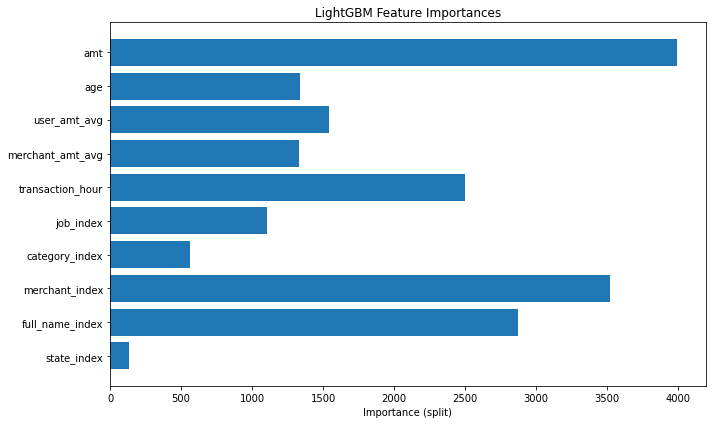

In [0]:
# Get the feature importances from the model
booster = gbm_model.stages[-1].getLightGBMBooster()                             # Get the last stage of the pipeline which is the LightGBM model

importance_list = booster.getFeatureImportances("split")                        # Get the feature importances based on the number of splits

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(final_features, importance_list)
plt.xlabel("Importance (split)")
plt.title("LightGBM Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In this feature importance plot, the most influential variable for the model is again amt (transaction amount), showing the highest contribution to the prediction. However, in this case, user_amt_avg (the user’s average transaction amount) and merchant_amt_avg (the merchant’s average transaction amount) also exhibit high importance, suggesting that behavioral spending patterns play a critical role in identifying fraudulent transactions. These features provide valuable context that helps the model assess whether a transaction deviates significantly from typical patterns, which is key in fraud detection.

In [0]:
# Load the saved models to avoid re-training
xgb_model = PipelineModel.load('/FileStore/models/xgb_model')
gbm_model = PipelineModel.load('/FileStore/models/gbm_model')

/local_disk0/.ephemeral_nfs/envs/pythonEnv-3a2e1373-621f-4f68-bf34-75f5ef886533/lib/python3.9/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [0]:
# Create StringIndexer stages for each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=f'{col}_index', handleInvalid='keep') 
            for col in categorical_columns]

# Create and fit the pipeline
indexer_pipeline = Pipeline(stages=indexers)
indexer_model = indexer_pipeline.fit(df_train)

# Transform the training DataFrame
final_df_train = indexer_model.transform(df_train)

In [0]:
xgb_model_stage = xgb_model.stages[-1]     
booster = xgb_model_stage.get_booster() 

explainer = shap.Explainer(booster)
shap_values = explainer(final_df_train.select(final_features).toPandas())

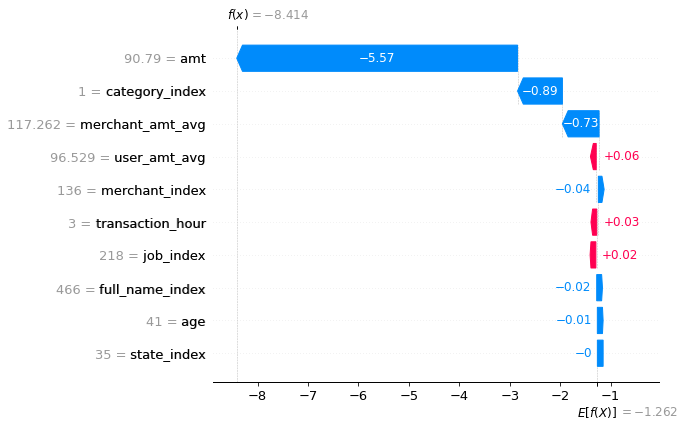

In [0]:
shap.plots.waterfall(shap_values[0])

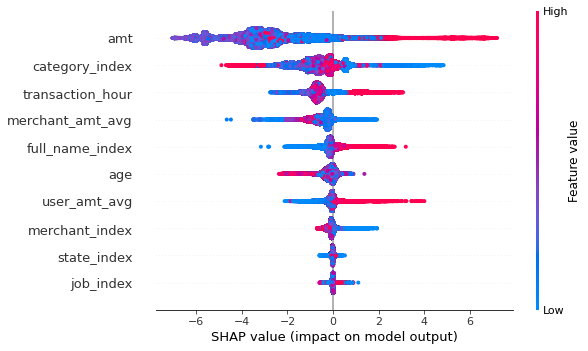

In [0]:
shap.plots.beeswarm(shap_values)